In [83]:
import pandas as pd
import numpy as np
import csv
import nltk
import nltk
nltk.download('stopwords')
#from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle
import re
from collections import Counter
from string import punctuation
import tweepy
from tweepy import OAuthHandler
import json
from wordcloud import WordCloud

import plotly
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

from IPython.display import IFrame
import folium
from folium import plugins
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMapWithTime


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
pd.set_option('display.max_colwidth', 1)
plt.style.use('seaborn-white')

In [85]:
# load train data
data = pd.read_csv('C:/Users/HOME/Downloads/Sentiment Analysis Dataset.csv',
                   error_bad_lines=False)

In [86]:
#1
data.columns = ['label','text','source']
data.head(2)

,label,text,source
0,negative,EXCLUSIVE: Paul Ryan working with Obama deep state to leak fake news | Third Estate Newsgroup https://t.co/2Rlnbz36fr,birdeyhunt
1,negative,RT @DonnaFiducia: It appears that Paul Ryan couldn’t destroy Trump while leading Congress so he’s doing it at @FoxNews to destroy what WE T…,tomorourke1


In [87]:
#2
# get text and matching label columns
data = data.drop(['source'],axis=1)
data.head(10)

,label,text
0,negative,EXCLUSIVE: Paul Ryan working with Obama deep state to leak fake news | Third Estate Newsgroup https://t.co/2Rlnbz36fr
1,negative,RT @DonnaFiducia: It appears that Paul Ryan couldn’t destroy Trump while leading Congress so he’s doing it at @FoxNews to destroy what WE T…
2,positive,RT @ClaudetteFrech1: @ACTBrigitte @DiamondandSilk Blame foxes Ceo Suzanne Scott and new board member Rino Paul Ryan most of all the Murdoch…
3,neutral,Investigate Paul Ryan #investigateRyan
4,positive,@katy_fit HaPpY bIrThDaY Ryan! 💥💥💥💥💥
5,neutral,@Thomas1774Paine two words:\nPaul\nRyan.\nHe destroyed the GOP congress and is gleefully doing the same at Fox.
6,neutral,"RT @TwistedPolitix: \Paul Ryan And Mitt Romney At Odds On Funding AmeriCorps\"" ( http://t.co/vd4anmEY #jacklew"""
7,positive,@Pedal2DMetals @FoxNews @FoxBusiness @trish_regan @donnabrazile Thanks to MURDOCK SR’S MEDIA WONDER BOYS &amp; STUPIDO… https://t.co/LaTCkftUV2
8,positive,RT @InGodIDoTrust: Mitch McConnell says he is ready to hand the Senate over to Chuck Schumer.\nHe is pulling a Paul Ryan.\n@realDonaldTrump
9,positive,@Paul_Rakszawski @ryanhoward @CSeidmanNBCS I’ve got the ahift helping him average-wise a little. Home run numbers a… https://t.co/HeVH1g9RUd


In [88]:
#3
# check the number of positive vs. negative tagged sentences
positives = data['label'][data.label == 'positive']
negatives = data['label'][data.label == 'negative']
neutral = data['label'][data.label == 'neutral']

print('number of positve tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('number of neutral tagged sentences is: {}'.format(len(neutral)))

print('total length of the data is:            {}'.format(data.shape[0]))


number of positve tagged sentences is:  34
number of negative tagged sentences is: 24
number of neutral tagged sentences is: 42
total length of the data is:            100


In [89]:
#4
# get unique label counts
data.groupby('label').describe()

text         \
         count unique   
label                   
negative  24    15      
neutral   42    33      
positive  34    18      

                                                                                                                                                        \
                                                                                                                                                   top   
label                                                                                                                                                    
negative  RT @susanf1028: 🤣🤣🤣 I just received an email from Paul Ryan asking for a donation. Told him to go fuck himself and how he’s ruined Fox News…   
neutral   RT @Pedal2DMetals: @JimTuscaloosaAl Oh yeah!   Tons of people are in agreement @marthamaccallum is a 3rd rate journalist hack who has sold…    
positive  RT @realDonaldTrump: ....Even the Radical Left Do Nothing Democrats laughed at the Fox suggestion. No respect for the people running @FoxNe…   

               
         freq  
label          
negative  6    
neutral   5    
positive  8

In [90]:
#5
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
data['word count'] = data['text'].apply(word_count)
data.head(3)

,label,text,word count
0,negative,EXCLUSIVE: Paul Ryan working with Obama deep state to leak fake news | Third Estate Newsgroup https://t.co/2Rlnbz36fr,17
1,negative,RT @DonnaFiducia: It appears that Paul Ryan couldn’t destroy Trump while leading Congress so he’s doing it at @FoxNews to destroy what WE T…,24
2,positive,RT @ClaudetteFrech1: @ACTBrigitte @DiamondandSilk Blame foxes Ceo Suzanne Scott and new board member Rino Paul Ryan most of all the Murdoch…,21


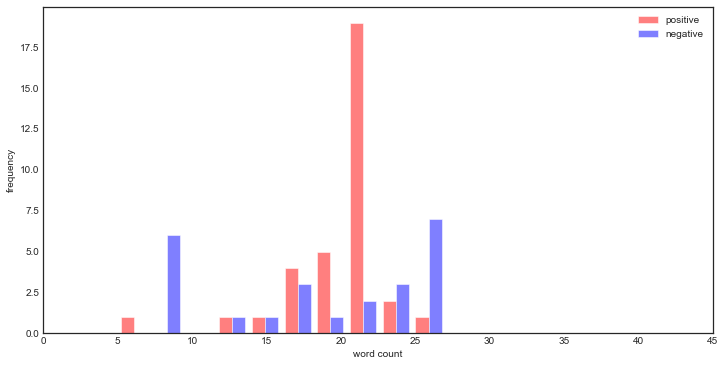

In [91]:
#6
# plot word count distribution for both positive and negative sentiments
x = data['word count'][data.label == 'positive']
y = data['word count'][data.label == 'negative']
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')



In [17]:
#7
# get most common words in training dataset
all_words = []
for line in list(data['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(10)



[('the', 68),
 ('paul', 64),
 ('rt', 58),
 ('ryan', 49),
 ('to', 46),
 ('and', 42),
 ('is', 39),
 ('fox', 32),
 ('a', 30),
 ('for', 23)]

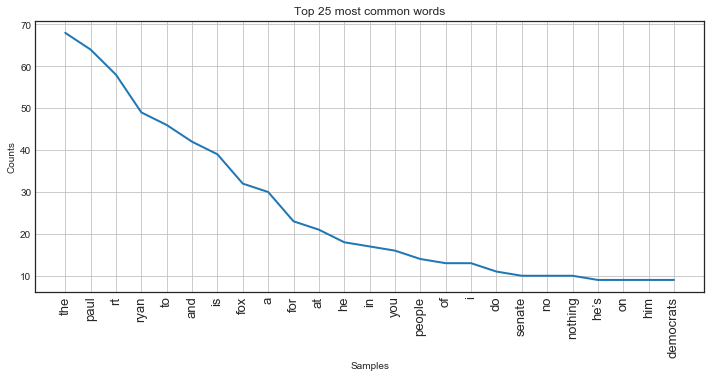

Text(0.5, 1.0, 'log-log plot of words frequency')

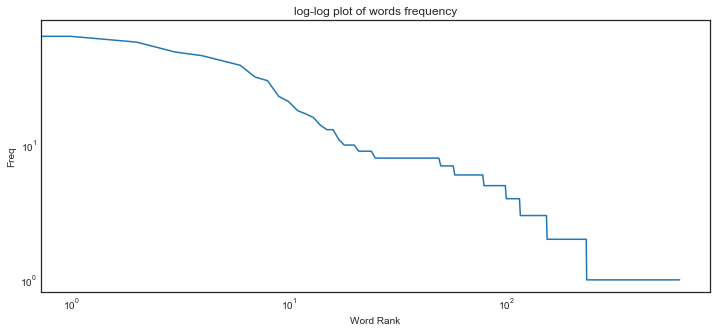

In [18]:
#8
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log plot
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency')


In [19]:
#9
# twitter api credentials - you need these to gain access to API
consumer_key = '----------------------------------------------'
consumer_secret = '----------------------------------------------'
access_token = '----------------------------------------------'
access_token_secret = '----------------------------------------------'

# instantiate the api
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)



In [20]:
#10
# string to search on twitter
query = 'paul AND ryan'

# open/create a csv file to append data
csvFile = open(query + '_data2.csv', 'w', encoding='utf-8')

# use csv Writer
csvWriter = csv.writer(csvFile)

# get data from twitter
tweet_num = 0
for tweet in tweepy.Cursor(api.search,q=query+ ' -RT',count=10000000,lang="en").items(100):
    if tweet.place is not None:
        try:
            # not entirely necessary but you can inspect what is being written to file
            print ('tweet number: {}'.format(tweet_num), tweet.text, tweet.place.full_name)
            # write data to csv
            csvWriter.writerow([tweet.created_at,
                                tweet.user.location,
                                tweet.user.followers_count,
                                tweet.user.friends_count,
                                tweet.text,
                                tweet.place.bounding_box.coordinates,
                                tweet.place.full_name,
                                tweet.place.country,
                                tweet.place.country_code,
                                tweet.place.place_type])
            tweet_num += 1
            
        except Exception:
            pass
     

tweet number: 0 @Lrihendry Paul Ryan the fraud is on the board.
FOX will start losing people soon. Vancouver, British Columbia


In [22]:
#11
# create column names
col_names=['date','user_loc','followers','friends','message','bbox_coords',\
           'full_name','country','country_code','place_type']

# read csv
df_twtr = pd.read_csv('C:/Users/HOME/Downloads/paul_ryan_twitter.csv', names=col_names)
# check head
df_twtr.head()

,date,user_loc,followers,friends,message,bbox_coords,full_name,country,country_code,place_type
0,2018-04-13 08:14:22,NaN,61,367,This is Paul Ryan. Exactly. 100%. Fuck Paul Ryan. https://t.co/MYxN9jOas8,"[[[-74.988897, 39.810025], [-74.908642, 39.810025], [-74.908642, 39.87514], [-74.988897, 39.87514]]]","Voorhees, NJ",United States,US,city
1,2018-04-13 08:01:58,"Long Island, NY",3656,3549,There's a video from the Daily Show (Comedy Central) you'll want to see.\r\nhttps://t.co/wjKUW9wBXo,"[[[-79.76259, 40.477383], [-71.777492, 40.477383], [-71.777492, 45.015851], [-79.76259, 45.015851]]]","New York, USA",United States,US,admin
2,2018-04-13 07:48:16,Alameda Ca,2304,2917,"@SallyAlbright First of all, discrediting the FBI is disgusting and borderline treasonous. Secondly, I wonder if t… https://t.co/BdnZrBCKhq","[[[-122.332411, 37.720367], [-122.224562, 37.720367], [-122.224562, 37.797229], [-122.332411, 37.797229]]]","Alameda, CA",United States,US,city
3,2018-04-13 07:45:37,"San Francisco, CA",52,876,Paul Ryan is a coward and a piece of shit! Good riddance! Now if the rest of the pieces of shit in that party would… https://t.co/kRCeUl3zej,"[[[-121.6919801, 36.643802], [-121.5905572, 36.643802], [-121.5905572, 36.7344965], [-121.6919801, 36.7344965]]]","Salinas, CA",United States,US,city
4,2018-04-13 07:30:20,"Greenville, SC",833,4367,@robreiner Paul Ryan realized he could not forever serve 2 gods-- that dual self-serving gospels would inevitably c… https://t.co/jaTMhFHDnR,"[[[-82.465548, 34.708643], [-82.418761, 34.708643], [-82.418761, 34.751491], [-82.465548, 34.751491]]]","Golden Grove, SC",United States,US,city


In [23]:
#12
# Sort dataframe by date column
df_twtr['date'] = pd.to_datetime(df_twtr['date'])
df_twtr = df_twtr.sort_values(by='date',ascending=True)
df_twtr = df_twtr.reset_index().drop('index',axis=1)
df_twtr.head()

,date,user_loc,followers,friends,message,bbox_coords,full_name,country,country_code,place_type
0,2018-04-09 23:52:02,"London, England",93,382,We’ll look back on today as the first time Paul Ryan said “...oh no” without a hint of irony.,"[[[-0.259465, 51.417277], [-0.127974, 51.417277], [-0.127974, 51.486036], [-0.259465, 51.486036]]]","Wandsworth, London",United Kingdom,GB,city
1,2018-04-09 23:56:39,NaN,4,1,PAUL RYAN AND MITCH McCONNELL ARE BIG SISSIES!!!,"[[[-80.519851, 39.719801], [-74.689517, 39.719801], [-74.689517, 42.516072], [-80.519851, 42.516072]]]","Pennsylvania, USA",United States,US,admin
2,2018-04-09 23:57:41,"Florida, USA",22,37,Were are McConell and Paul Ryan your silence is sickening @realDonaldTrump @maga @POTUS,"[[[-80.173447, 26.476484], [-80.05236, 26.476484], [-80.05236, 26.5904875], [-80.173447, 26.5904875]]]","Boynton Beach, FL",United States,US,city
3,2018-04-10 00:00:04,New York City,1454,3053,@RealDonalDrumpf @tperkins Over/Under-on-Paul-Ryan-as-Potus-by-Cinco-De-Impeacho-?,"[[[-74.026675, 40.683935], [-73.910408, 40.683935], [-73.910408, 40.877483], [-74.026675, 40.877483]]]","Manhattan, NY",United States,US,city
4,2018-04-10 00:03:42,"Miami, FL",4,35,@kylegriffin1 where are Paul Ryan or mitch mcconnell ???,"[[[-80.321683, 25.7090404], [-80.144974, 25.7090404], [-80.144974, 25.855667], [-80.321683, 25.855667]]]","Miami, FL",United States,US,city


In [24]:
#13
# get central geo location from the bounding box for later mapping

# helper function to get mean of lats and longs
def geo_mean(x):
    y = json.loads(x)
    y = np.asarray(y)
    mean_geoloc = np.add(np.add((y[:][0][0]),(y[:][0][1]))/2,\
                         (np.add((y[:][0][2]),(y[:][0][3]))/2))/2    
    return np.around(mean_geoloc,decimals=6)

# ____________________________________________________________

# append new column  and clean up df
df_twtr['geo_code'] = df_twtr['bbox_coords'].apply(geo_mean)
df_twtr = df_twtr.drop(['bbox_coords','place_type','followers','friends'],axis=1)
df_twtr.head()

,date,user_loc,message,full_name,country,country_code,geo_code
0,2018-04-09 23:52:02,"London, England",We’ll look back on today as the first time Paul Ryan said “...oh no” without a hint of irony.,"Wandsworth, London",United Kingdom,GB,"[-0.19372, 51.451656]"
1,2018-04-09 23:56:39,NaN,PAUL RYAN AND MITCH McCONNELL ARE BIG SISSIES!!!,"Pennsylvania, USA",United States,US,"[-77.604684, 41.117936]"
2,2018-04-09 23:57:41,"Florida, USA",Were are McConell and Paul Ryan your silence is sickening @realDonaldTrump @maga @POTUS,"Boynton Beach, FL",United States,US,"[-80.112903, 26.533486]"
3,2018-04-10 00:00:04,New York City,@RealDonalDrumpf @tperkins Over/Under-on-Paul-Ryan-as-Potus-by-Cinco-De-Impeacho-?,"Manhattan, NY",United States,US,"[-73.968542, 40.780709]"
4,2018-04-10 00:03:42,"Miami, FL",@kylegriffin1 where are Paul Ryan or mitch mcconnell ???,"Miami, FL",United States,US,"[-80.233328, 25.782354]"


In [25]:
#14
df_twtr.to_pickle('df_paulry.p') # save dframe to pickle

In [26]:
#15
df_paulry = pd.read_pickle('df_paulry.p')  # load from pickle

In [40]:
#16
# helper function to clean tweets
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet
# ______________________________________________________________

# clean dataframe's text column
df_paulry['message'] = df_paulry['message'].apply(processTweet)
# preview some cleaned tweets
df_paulry['message'].head()

0    ’ look back today the first time paul ryan said “ ” without hint irony 
1    paul ryan and mitch mcconnell are big sissies                          
2    were are mcconell and paul ryan your silence sickening                 
3    over under paul ryan potus cinco impeacho                              
4    where are paul ryan mitch mcconnell                                    
Name: message, dtype: object

In [28]:
#17
before = df_paulry['message'][600]
after = processTweet(before)

before,'\n',after

('house speaker paul ryan won seek election ',
 '\n',
 'house speaker paul ryan won seek election ')

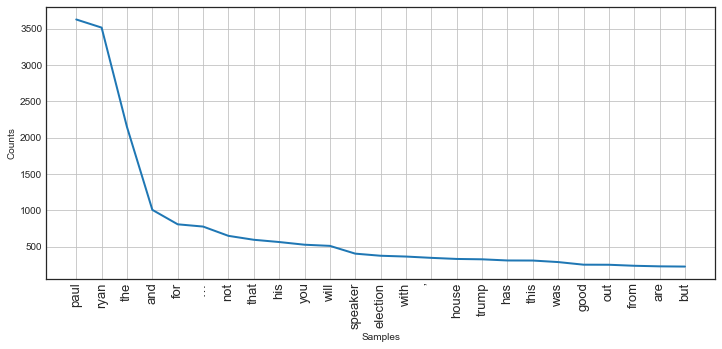

Text(0.5, 0, 'Word Rank')

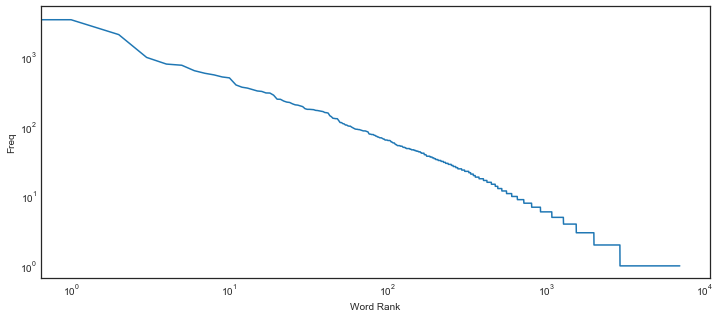

In [29]:
#18
# most common words in twitter dataset
all_words = []
for line in list(df_paulry['message']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())

# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)

plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

In [30]:
#19
# drop duplicates
df_paulry = df_paulry.drop_duplicates('message')
df_paulry.shape

(3966, 7)

In [31]:
#20
# show stop words examples
stop_words = stopwords.words('english') # Show some stop words
' , '.join(stop_words)[:200], len(stop_words)

("i , me , my , myself , we , our , ours , ourselves , you , you're , you've , you'll , you'd , your , yours , yourself , yourselves , he , him , his , himself , she , she's , her , hers , herself , it ",
 179)

In [41]:
#21
# tokenize helper function
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]


def remove_words(word_list):
    remove = ['paul','ryan','...','“','”','’','…','ryan’']
    return [w for w in word_list if w not in remove]

# -------------------------------------------

# tokenize message column and create a column for tokens
df_paulry = df_paulry.copy()
df_paulry['tokens'] = df_paulry['message'].apply(text_process) # tokenize style 1
df_paulry['no_pauls'] = df_paulry['tokens'].apply(remove_words) #tokenize style 2
df_paulry.head()

,date,user_loc,message,full_name,country,country_code,geo_code,tokens,no_pauls
0,2018-04-09 23:52:02,"London, England",’ look back today the first time paul ryan said “ ” without hint irony,"Wandsworth, London",United Kingdom,GB,"[-0.19372, 51.451656]","[’, look, back, today, first, time, paul, ryan, said, “, ”, without, hint, irony]","[look, back, today, first, time, said, without, hint, irony]"
1,2018-04-09 23:56:39,NaN,paul ryan and mitch mcconnell are big sissies,"Pennsylvania, USA",United States,US,"[-77.604684, 41.117936]","[paul, ryan, mitch, mcconnell, big, sissies]","[mitch, mcconnell, big, sissies]"
2,2018-04-09 23:57:41,"Florida, USA",were are mcconell and paul ryan your silence sickening,"Boynton Beach, FL",United States,US,"[-80.112903, 26.533486]","[mcconell, paul, ryan, silence, sickening]","[mcconell, silence, sickening]"
3,2018-04-10 00:00:04,New York City,over under paul ryan potus cinco impeacho,"Manhattan, NY",United States,US,"[-73.968542, 40.780709]","[paul, ryan, potus, cinco, impeacho]","[potus, cinco, impeacho]"
4,2018-04-10 00:03:42,"Miami, FL",where are paul ryan mitch mcconnell,"Miami, FL",United States,US,"[-80.233328, 25.782354]","[paul, ryan, mitch, mcconnell]","[mitch, mcconnell]"


In [43]:
#22
# style 1 tokens
df_paulry['tokens'].head(10)

0    [’, look, back, today, first, time, paul, ryan, said, “, ”, without, hint, irony]             
1    [paul, ryan, mitch, mcconnell, big, sissies]                                                  
2    [mcconell, paul, ryan, silence, sickening]                                                    
3    [paul, ryan, potus, cinco, impeacho]                                                          
4    [paul, ryan, mitch, mcconnell]                                                                
5    [think, chances, mitch, mcconnell, paul, ryan, grow, ball…]                                   
6    [time, time, state, look, demarcated, get, ready, vote, democrats, paul, ryan, bill, defeated]
7    [cbo, currently, headed, republican, voted, paul, ryan, gop, house, right…]                   
8    [sorry, damn, thing, paul, ryan, mitch, mcconnell, afraid, donald, trump, …]                  
9    [time, paul, ryan, take, hike]                                                                


In [44]:
#23
# style 2 tokens
df_paulry['no_pauls'].head(10)

0    [look, back, today, first, time, said, without, hint, irony]                      
1    [mitch, mcconnell, big, sissies]                                                  
2    [mcconell, silence, sickening]                                                    
3    [potus, cinco, impeacho]                                                          
4    [mitch, mcconnell]                                                                
5    [think, chances, mitch, mcconnell, grow, ball…]                                   
6    [time, time, state, look, demarcated, get, ready, vote, democrats, bill, defeated]
7    [cbo, currently, headed, republican, voted, gop, house, right…]                   
8    [sorry, damn, thing, mitch, mcconnell, afraid, donald, trump]                     
9    [time, take, hike]                                                                
Name: no_pauls, dtype: object

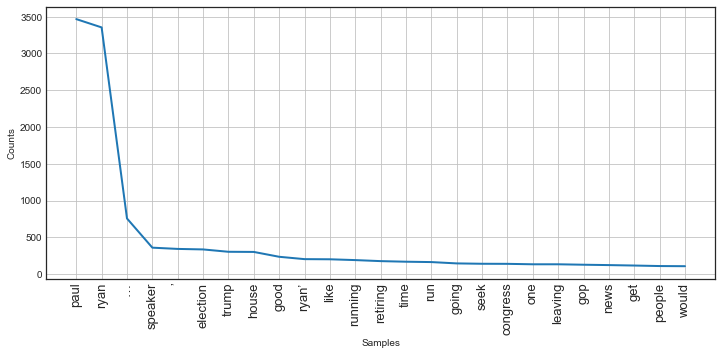

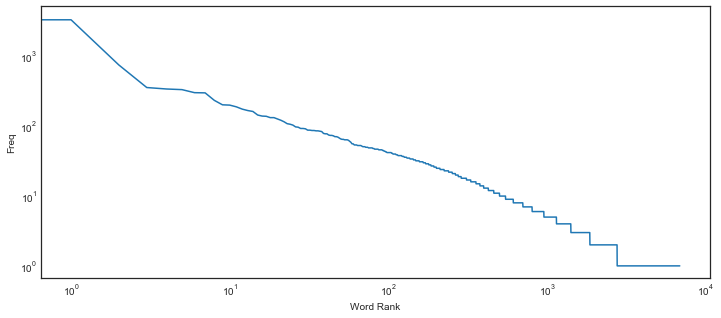

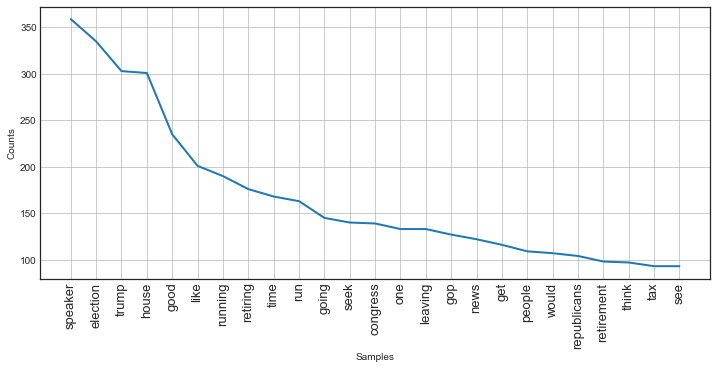

Text(0.5, 0, 'Word Rank')

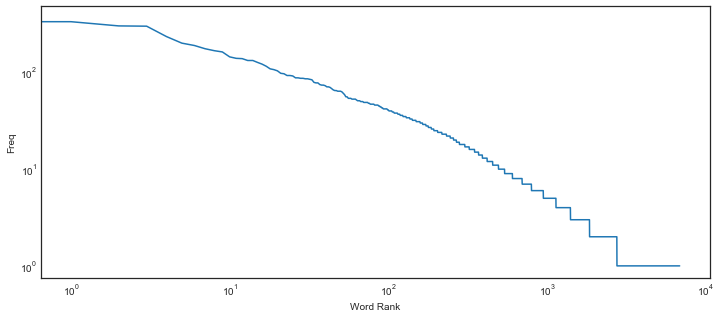

In [45]:
#24
# most common words in twitter dataset
all_words = []
for ls in df_paulry['tokens']:
    words = [w for w in ls]
    for word in words:
        all_words.append(word.lower())
    
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log  of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

# plot word frequency distribution of first few words without paul, ryan
# no_pauls
no_pauls = []
for ls in df_paulry['no_pauls']:
    words = [w for w in ls]
    for word in words:
        no_pauls.append(word)
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(no_pauls)
fd.plot(25,cumulative=False)

# log-log  of all words -- no_pauls 
word_counts = sorted(Counter(no_pauls).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

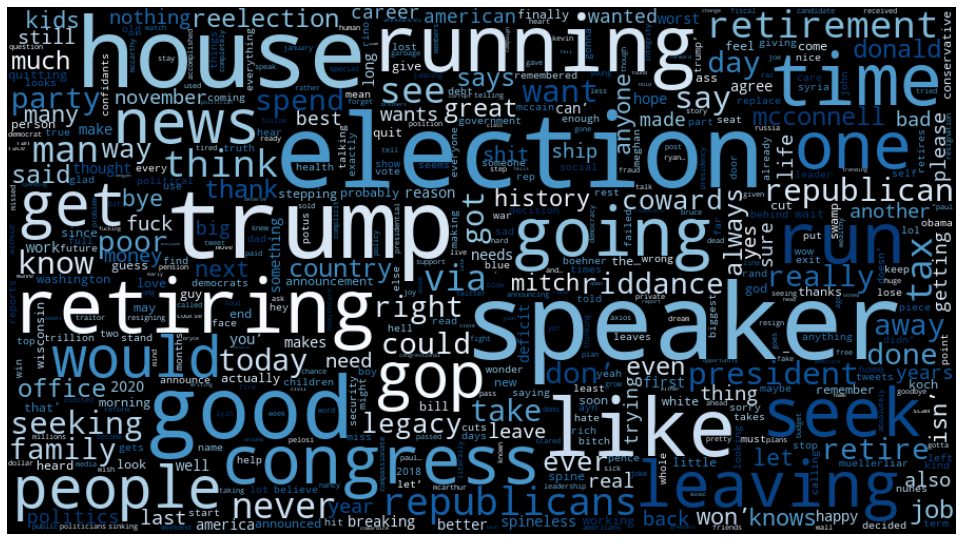

In [46]:
#25
# split sentences to get individual words
all_words = []
for line in df_paulry['no_pauls']: # try 'tokens'
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [47]:
#26
# vetorize
bow_transformer = CountVectorizer(analyzer=text_process).fit(df_paulry['message'])
# print total number of vocab words
print(len(bow_transformer.vocabulary_))

6865


In [48]:
#27
# example of vectorized text
sample_tweet = df_paulry['message'][111]
print(sample_tweet)
print('\n')
# vector representation
bow_sample = bow_transformer.transform([sample_tweet])
print(bow_sample)
print('\n')

president paul ryan here come 


  (0, 1148)	1
  (0, 4138)	1
  (0, 4406)	1
  (0, 5057)	1




In [49]:
#28
# transform the entire DataFrame of messages
messages_bow = bow_transformer.transform(df_paulry['message'])

# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (3966, 6865)
Amount of Non-Zero occurences:  36660


In [50]:
#29
# from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf_sample = tfidf_transformer.transform(bow_sample)
print(tfidf_sample)

  (0, 5057)	0.15548606691496553
  (0, 4406)	0.6320888004918337
  (0, 4138)	0.14967651926943595
  (0, 1148)	0.7442343521146387


In [51]:
#30

# some IDF (inverse document frequency) example
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['trump']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['gop']])

3.619338732401898
4.4654838549092934


In [52]:
#31

# to transform the entire bag-of-words corpus
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(3966, 6865)


In [53]:
#Naive Bayes 
#32
# Run Train Data Through Pipeline analyzer=text_process
# uncomment below to train on a larger dataset but it is very slow for a regular laptop

# X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data['text'][:5000], data['label'][:5000], test_size=0.2)


# create pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            stop_words='english',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-2, 1e-3),
             }

# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)

# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Best Model: 0.687500 using {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}


Mean: 0.675000 Stdev:(0.150000) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.687500 Stdev:(0.150520) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.675000 Stdev:(0.150000) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.687500 Stdev:(0.150520) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}
Mean: 0.675000 Stdev:(0.114564) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.687500 Stdev:(0.115244) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.675000 Stdev:(0.114564) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.687500 Stdev:(0.115244) with: {'bow__ngram_range'

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.8s finished


In [54]:
#33
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")

['twitter_sentiment.pkl']

In [55]:
#34
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )

# get predictions from best model above
y_preds = model_NB.predict(X_test)

print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))

accuracy score:  0.65


confusion matrix: 
 [[1 1 0]
 [4 6 0]
 [2 0 6]]


              precision    recall  f1-score   support

    negative       0.14      0.50      0.22         2
     neutral       0.86      0.60      0.71        10
    positive       1.00      0.75      0.86         8

    accuracy                           0.65        20
   macro avg       0.67      0.62      0.60        20
weighted avg       0.84      0.65      0.72        20



In [56]:
#35
# run predictions on twitter data
tweet_preds = model_NB.predict(df_twtr['message'])

# append predictions to dataframe
df_tweet_preds = df_twtr.copy()
df_tweet_preds['predictions'] = tweet_preds
df_tweet_preds.shape

(4164, 8)

In [57]:
#36
# print text and sentiment

index = random.sample(range(tweet_preds.shape[0]), 20)
for text, sentiment in zip(df_tweet_preds.message[index],
                           df_tweet_preds.predictions[index]):
    print (sentiment, '--', text, '\n')

neutral -- So yeah, this happened this morning. Paul Ryan has ran out of people’s lives to ruin, I guess. https://t.co/FcsLjaEhZM 

negative -- Paul Ryan is alleged to now have a shoot at a big lobbyist group! 

negative -- Paul Ryan’s dipping before the storm... 

negative -- Keep up the fight...it's working! #Resist ✊🏾~
House Speaker Paul Ryan won’t seek reelection, according to people wi… https://t.co/21EiRglECf 

negative -- This is Paul Ryan. Exactly. 100%. Fuck Paul Ryan. https://t.co/MYxN9jOas8 

negative -- West Va. Delegation reacts to Paul Ryan plans for retirement.  https://t.co/RLPmKJtfzt 

negative -- Most times I agree with you.  Paul Ryan is not supposed to be a team player, he’s supposed to lead.  When someone g… https://t.co/1CfTHg0n6R 

negative -- @TeaPainUSA Is it Paul Ryan? 

positive -- US Opinion | A scam of a party says goodbye to its top fraud https://t.co/VBm9oHlil2 

negative -- Wow Paul Ryan will not seek re-election. 

positive -- It’s a great day in Americ

In [58]:
#37
# Testing random text from the internet

# load model
model_NB = joblib.load("twitter_sentiment.pkl" )

# test string
sample_str = """While ride-sharing first mover Uber has fallen on tough times with
scandal and abyssal track records of leadership, and cash burning
growth-orientated practices, the world has caught up with self-driving
tech with many players now in the race."""


p = model_NB.predict([sample_str])

# formatting helper
def sentiment_str(x):
    if x=='positive':
        return 'Positive'
    else:
        return 'Negative'
#_____________________________________________

# test result ___ 0=Negative, 1=Positive
print("the sentence: \n\n'{}' \n\nhas a {} sentiment".format(sample_str,sentiment_str(p[0])))

the sentence: 

'While ride-sharing first mover Uber has fallen on tough times with
scandal and abyssal track records of leadership, and cash burning
growth-orientated practices, the world has caught up with self-driving
tech with many players now in the race.' 

has a Negative sentiment


In [59]:
#38
pos = df_tweet_preds.predictions.value_counts()[0]
neg = df_tweet_preds.predictions.value_counts()[1]

print('Model predictions: Positives - {}, Negatives - {}'.format(neg,pos))

Model predictions: Positives - 1263, Negatives - 1908


In [60]:
#39
# save dataframe with appended preditions 
df_tweet_preds.to_pickle('paulry_predicts_df.p')

In [61]:
#40

# load dataframe with predictions
df = pd.read_pickle('paulry_predicts_df.p')
df.head()

,date,user_loc,message,full_name,country,country_code,geo_code,predictions
0,2018-04-09 23:52:02,"London, England",We’ll look back on today as the first time Paul Ryan said “...oh no” without a hint of irony.,"Wandsworth, London",United Kingdom,GB,"[-0.19372, 51.451656]",neutral
1,2018-04-09 23:56:39,NaN,PAUL RYAN AND MITCH McCONNELL ARE BIG SISSIES!!!,"Pennsylvania, USA",United States,US,"[-77.604684, 41.117936]",positive
2,2018-04-09 23:57:41,"Florida, USA",Were are McConell and Paul Ryan your silence is sickening @realDonaldTrump @maga @POTUS,"Boynton Beach, FL",United States,US,"[-80.112903, 26.533486]",positive
3,2018-04-10 00:00:04,New York City,@RealDonalDrumpf @tperkins Over/Under-on-Paul-Ryan-as-Potus-by-Cinco-De-Impeacho-?,"Manhattan, NY",United States,US,"[-73.968542, 40.780709]",negative
4,2018-04-10 00:03:42,"Miami, FL",@kylegriffin1 where are Paul Ryan or mitch mcconnell ???,"Miami, FL",United States,US,"[-80.233328, 25.782354]",positive


In [62]:
#41

# get all the countries in dataset
df.country.unique()

array(['United Kingdom', 'United States', 'Canada', 'Spain', 'Ireland',
       'Iceland', 'El Salvador', 'Sweden', nan, 'Australia',
       'Dominican Republic', 'France', 'Mexico', 'Republic of Korea',
       'Thailand', 'Afghanistan', 'Belgium', 'Denmark', 'Chile',
       'Germany', 'Jamaica', 'Japan', 'Kenya', 'Finland', 'Greece',
       'Uganda', 'Singapore', 'Hong Kong', 'Lebanon', 'Argentina',
       'Nigeria', 'Malaysia', 'Brazil', 'The Netherlands', 'India',
       'Poland', 'Turkey', 'Virgin Islands, U.S.', 'New Zealand',
       'United Arab Emirates', 'Norway', 'Italy',
       'Former Yugoslav Republic of Macedonia', 'Bermuda', 'Indonesia'],
      dtype=object)

In [63]:
#42
# get top countries in the dataset by percentage of tweets
df.country.value_counts(1).head(10)

United States     0.928589
Canada            0.025727
United Kingdom    0.012263
Australia         0.010579
Ireland           0.002164
Germany           0.002164
Sweden            0.001924
Japan             0.001683
Spain             0.001202
Brazil            0.001202
Name: country, dtype: float64

Text(0, 0.5, '% of Total Tweets')

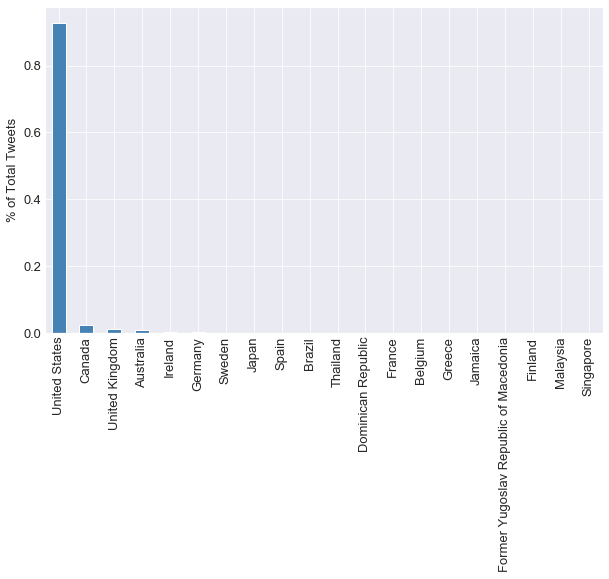

In [64]:
#43

# plot histogram of tweets counts by country of origin
sns.set_style("darkgrid")
x = df.country.value_counts(1).head(20)
x.plot(kind='bar',figsize=(10,6),fontsize=13,color='steelblue')
plt.ylabel('% of Total Tweets', fontsize=13)

In [66]:
#44
# get latitudes and longitudes

# some helper funtions to get longs and lats
def lats(x):
    return x[1]

def longs(x):
    return x[0]

# --------------------------------------------------------#
# append longs and lats to dframe
df['latitude'] = df['geo_code'].apply(lats)
df['longitude'] = df['geo_code'].apply(longs)
df.columns

Index(['date', 'user_loc', 'message', 'full_name', 'country', 'country_code',
       'geo_code', 'predictions', 'latitude', 'longitude'],
      dtype='object')

In [67]:
#45

# for US tweets extract state abreviations for a new STATE column
# helper function to extract state origin of every tweet
def get_state(x):
    
    states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
              "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
              "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
              "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
              "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

    states_dict = {
            'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa',
            'AZ': 'Arizona','CA': 'California','CO': 'Colorado','CT': 'Connecticut',
            'DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia',
            'GU': 'Guam','HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho','IL': 'Illinois',
            'IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana',
            'MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan',
            'MN': 'Minnesota','MO': 'Missouri','MP': 'Northern Mariana Islands',
            'MS': 'Mississippi','MT': 'Montana','NA': 'National','NC': 'North Carolina',
            'ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey',
            'NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio','OK': 'Oklahoma',
            'OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico','RI': 'Rhode Island',
            'SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas',
            'UT': 'Utah','VA': 'Virginia','VI': 'Virgin Islands','VT': 'Vermont',
            'WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'
    }


    abv = x.split(',')[-1].lstrip().upper()
    state_name = x.split(',')[0].lstrip()
    if abv in states:
        state = abv
    else:
        if state_name in states_dict.values():
            state = list(states_dict.keys())[list(states_dict.values()).index(state_name)]
        else:
            state = 'Non_USA'    
    return state

# ____________________________________________________________________________

# create abreviated states column
df = df.copy()
df['states'] = df['full_name'].apply(get_state)
list(df['states'].head())

['Non_USA', 'PA', 'FL', 'NY', 'FL']

In [68]:
#46
# save updated dataframe
df.to_pickle('df_paulry_longs_lats.p')

In [69]:
#47
# retrive updated dataframe
df = pd.read_pickle('df_paulry_longs_lats.p')

Text(0, 0.5, 'Origin of Tweets')

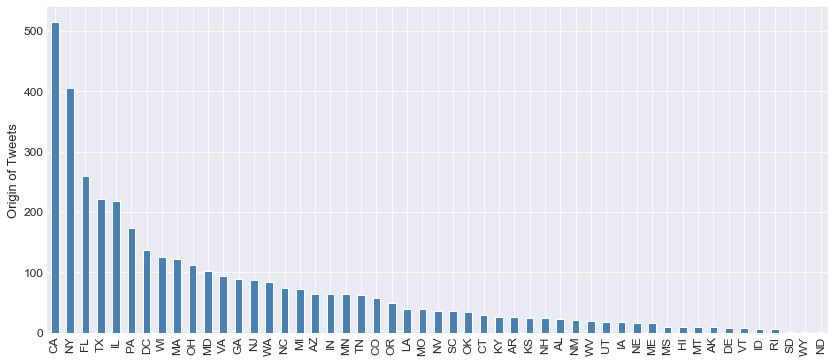

In [70]:
#48
# plot tweets distribution by state

plt.style.use('seaborn-darkgrid')
df_states = df[df.country=='United States']
df_states = df_states[df_states.states!='Non_USA']

x = df_states.states.value_counts()
x.plot(kind='bar',figsize=(14,6),fontsize=12,color='steelblue')
plt.ylabel('Origin of Tweets', fontsize=13)

In [71]:
#49
# extract total sentiment per state
df_state_sentiment = df_states.groupby(['states'])['predictions'].value_counts().unstack().fillna(0.0).reset_index()
df_state_sentiment['total_sentiment'] = -(df_state_sentiment['negative'])+df_state_sentiment['positive'] 
df_state_sentiment[15:24]

predictions,states,negative,neutral,positive,total_sentiment
15,IN,26.0,19.0,20.0,-6.0
16,KS,11.0,8.0,5.0,-6.0
17,KY,13.0,9.0,5.0,-8.0
18,LA,10.0,16.0,14.0,4.0
19,MA,62.0,27.0,33.0,-29.0
20,MD,47.0,25.0,31.0,-16.0
21,ME,5.0,5.0,6.0,1.0
22,MI,36.0,17.0,19.0,-17.0
23,MN,27.0,14.0,23.0,-4.0


In [72]:
# Create the sentiment by state Heat Map
colorscale=[
            [0, 'rgb(31,120,180)'], 
            [0.35, 'rgb(166, 206, 227)'], 
            [0.75, 'rgb(251,154,153)'], 
            [1, 'rgb(227,26,28)']
           ]
data = dict(type='choropleth',
            colorscale = colorscale,
            reversescale=True,
            locations = df_state_sentiment['states'],
            z = df_state_sentiment['total_sentiment'],
            locationmode = 'USA-states',
            text = df_state_sentiment['states'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"Twitter Sentiment"}
            )
layout = dict(title = 'Twitter Sentiment: GOP House Speaker: Paul Ryan',
              geo = dict(scope='usa'
                        )
             )
choromap_us = go.Figure(data = [data],layout = layout)
plotly.offline.plot(choromap_us, filename='img_map.html')  # save html map
IFrame('img_map.html', width=950, height=700)  # view saved map html file